# Анализ воронки

- [Загрузка данных кликстрима из файла [`click_stream.csv`](data/click_stream.csv "click stream")](#Эволюция-воронки-со-временем)
- [Построение воронок по каждому доступному месяцу](#Воронки-по-месяцам)
(их всего 4: с января по апрель 2015 года)
- [Сравнение воронок: одинаковые ли воронки или меняются](#Сравнение--воронок)
- [Конверсия из поиска](#Конверсия-из-поиска)

Для того чтобы проанализировать воронку и понять что можно улучшить, нужно локализовать проблему.
Сначала оценим динамику со временем.

## Эволюция воронки со временем

Загрузим данные и рассчитаем конверсию по каждому доступному месяцу. Сравним полученные воронки.

In [1]:
import csv
from collections import OrderedDict

funnel_by_month = {} # создаем словарь, где будут храниться словари за каждый месяц
funnel_template = {'1_home_page':0, '2_search_page':0, '3_payment_page':0, '4_payment_confirmation_page':0}

with open('data/click_stream.csv', mode='r') as csv_file: # открываем файл
    csv_reader = csv.DictReader(csv_file, fieldnames=['ID','page','date']) # читаем файл
    
    # проходим циклом по объекту csv_reader
    for row in csv_reader: # берем строку из объекта csv_reader

        page = list(row.values())[1] # вытаскиваем название страницы
        event_date = list(row.values())[2][:-3] # вытаскиваем дату в формате YYYY-MM
        
        # проверяем существует ли ключ со значением event_date в словаре
        if event_date not in funnel_by_month: # если нет
            funnel_by_month[event_date] = funnel_template.copy() # создаем ключ, в значение копируем заготовку

        # проверяем условиями и прибавляем единицу к нужному ключу в словаре
        if page == '1_home_page':
            funnel_by_month[event_date][page] += 1
        elif page == '2_search_page':
            funnel_by_month[event_date][page] += 1
        elif page == '3_payment_page':
            funnel_by_month[event_date][page] += 1
        else:
            funnel_by_month[event_date][page] += 1
            
funnel_by_month = dict(OrderedDict(sorted(funnel_by_month.items(), key=lambda x: x[0])))
funnel_by_month

{'2015-01': {'1_home_page': 22600,
  '2_search_page': 13554,
  '3_payment_page': 2390,
  '4_payment_confirmation_page': 189},
 '2015-02': {'1_home_page': 22600,
  '2_search_page': 13687,
  '3_payment_page': 2412,
  '4_payment_confirmation_page': 173},
 '2015-03': {'1_home_page': 22600,
  '2_search_page': 8879,
  '3_payment_page': 631,
  '4_payment_confirmation_page': 44},
 '2015-04': {'1_home_page': 22600,
  '2_search_page': 9080,
  '3_payment_page': 597,
  '4_payment_confirmation_page': 46}}

## Воронки по месяцам

In [2]:
import pandas as pd
import numpy as np
df = pd.DataFrame(funnel_by_month)
df

,2015-01,2015-02,2015-03,2015-04
1_home_page,22600,22600,22600,22600
2_search_page,13554,13687,8879,9080
3_payment_page,2390,2412,631,597
4_payment_confirmation_page,189,173,44,46


На *главной странице* `home_page` количество посещений идентично во всех месяцах. Но потом начинаются изменения. Колическо переходов на *страницу поиска* `search_page` резко падает, количество переходов на *страницу платежа* `payment_page` тоже падает. А итогова конверсия перехода на *страницу подтверждения покупки* `payment_confirmation_page` падает очень-очень сильно.

Чтобы понять насколько сильно падает конверсия, представим эти данные на графике

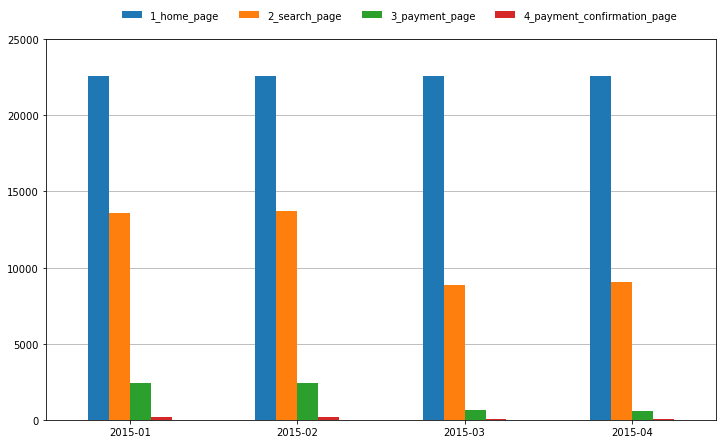

In [3]:
%matplotlib inline
bar = df.T.plot.bar(ylim=(0,25000), figsize=(12,7), rot=0)
bar.legend(loc=2, bbox_to_anchor=(0.1, 1, 1, 0.1), ncol=4, frameon=False)
bar.grid(axis='y')
bar.set_axisbelow(True)

## Сравнение  воронок

На приведённом графике видно, что количество переходов на *страницу поиска* `search_page` падает примерно на треть. А вот количество переходов на *страницу оплаты* `payment_page` падает в разы. Что же касается переходов на страницу *завершения оплаты* `payment_confirmation_page`, то видно, что в *последние два месяца* эта величина настолько ***мала***, что её даже *не видно на графике*. И поэтому для неё построим отдельный график.

In [4]:
df_diag = df.iloc[3:, :].T
df_diag['month'] = df_diag.index
df_diag

,4_payment_confirmation_page,month
2015-01,189,2015-01
2015-02,173,2015-02
2015-03,44,2015-03
2015-04,46,2015-04


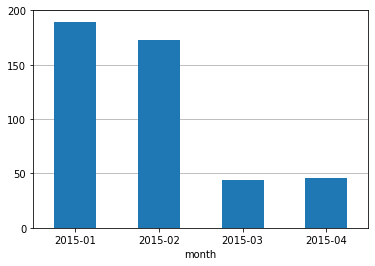

In [5]:
bar = df_diag.plot.bar(x='month', y='4_payment_confirmation_page', yticks=np.arange(0,210,50), ylim=(0,200), rot=0, legend=None)
bar.grid(axis='y')
bar.set_axisbelow(True)

На этом графике изображена **динамика по месяцам** количества людей, которые **завершили покупку** на сайте.<br>
Каждый месяц приходило одинаковое количество людей, но по этому графику видно, что количество людей, которые *завершили покупку* <u>**упало** почти в **4 раза**!</u> Это очень серьёзно.

Теперь представим целевую таблицу не в абсолютных числах, а в процентах, т.к. проценты сравнивать намного проще и надёжнее.

In [6]:
funnel_by_month_cent = {}

for key1, value1 in funnel_by_month.copy().items():
    base = value1.copy()['1_home_page']
    funnel_by_month_cent[key1] = value1.copy()
    for key2, value2 in value1.items():
        funnel_by_month_cent[key1][key2] = round(value2 / base * 100, 2)
funnel_by_month_cent

{'2015-01': {'1_home_page': 100.0,
  '2_search_page': 59.97,
  '3_payment_page': 10.58,
  '4_payment_confirmation_page': 0.84},
 '2015-02': {'1_home_page': 100.0,
  '2_search_page': 60.56,
  '3_payment_page': 10.67,
  '4_payment_confirmation_page': 0.77},
 '2015-03': {'1_home_page': 100.0,
  '2_search_page': 39.29,
  '3_payment_page': 2.79,
  '4_payment_confirmation_page': 0.19},
 '2015-04': {'1_home_page': 100.0,
  '2_search_page': 40.18,
  '3_payment_page': 2.64,
  '4_payment_confirmation_page': 0.2}}

In [7]:
df_c = pd.DataFrame(funnel_by_month_cent)
df_c.style.format('{:.2f}%')

,2015-01,2015-02,2015-03,2015-04
1_home_page,100.00%,100.00%,100.00%,100.00%
2_search_page,59.97%,60.56%,39.29%,40.18%
3_payment_page,10.58%,10.67%,2.79%,2.64%
4_payment_confirmation_page,0.84%,0.77%,0.19%,0.20%


Здесь видно, что конверсия из *посетителей* в *поиск* падает с примерно **60%** до **40%** - на **20%** (очень много), а конверсия в *покупателй* падает с **0.8%** до **0.2%** - т.е. **в 4 раза**. При этом видно, что конверсия из *поиска* в дальнейшие шаги, - тоже отличается по месяцам, но в таком представлении её неочень чётко видно. И поэтому, попробуем представить конверсию, приняв за 100% *поиск* в соответствующем месяце.

In [8]:
funnel_by_month_search_cent = {}

for key1, value1 in funnel_by_month.copy().items():
    base = value1.copy()['2_search_page']
    funnel_by_month_search_cent[key1] = value1.copy()
    for key2, value2 in value1.items():
        funnel_by_month_search_cent[key1][key2] = round(value2 / base * 100, 2)
funnel_by_month_search_cent

{'2015-01': {'1_home_page': 166.74,
  '2_search_page': 100.0,
  '3_payment_page': 17.63,
  '4_payment_confirmation_page': 1.39},
 '2015-02': {'1_home_page': 165.12,
  '2_search_page': 100.0,
  '3_payment_page': 17.62,
  '4_payment_confirmation_page': 1.26},
 '2015-03': {'1_home_page': 254.53,
  '2_search_page': 100.0,
  '3_payment_page': 7.11,
  '4_payment_confirmation_page': 0.5},
 '2015-04': {'1_home_page': 248.9,
  '2_search_page': 100.0,
  '3_payment_page': 6.57,
  '4_payment_confirmation_page': 0.51}}

In [9]:
df_s_c = pd.DataFrame(funnel_by_month_search_cent)
df_s_c = df_s_c.iloc[1:, :]
df_s_c.style.format('{:.2f}%')

,2015-01,2015-02,2015-03,2015-04
2_search_page,100.00%,100.00%,100.00%,100.00%
3_payment_page,17.63%,17.62%,7.11%,6.57%
4_payment_confirmation_page,1.39%,1.26%,0.50%,0.51%


## Конверсия из поиска

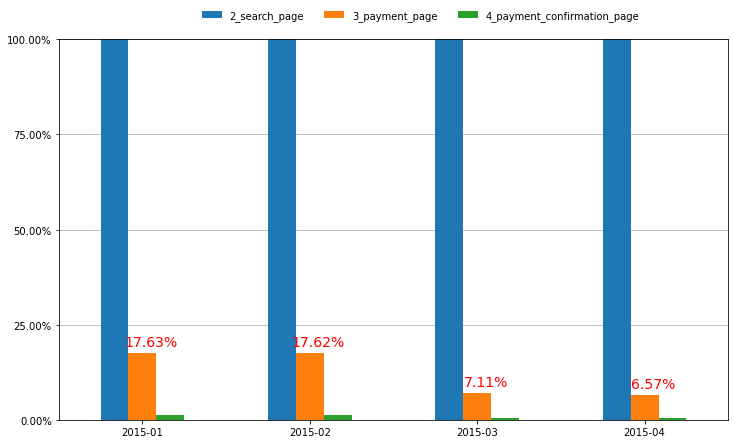

In [10]:
bar = df_s_c.T.plot.bar(figsize=(12,7), rot=0, ylim=(0,100), yticks=np.arange(0,110,25))
bar.set_yticklabels([f'{y:.2f}%' for y in np.arange(0,101,25)])
for x, y in enumerate(df_s_c.T['3_payment_page'].values):
    bar.text(x+.05, y+1, f'{y:.2f}%', ha='center', va='bottom', color='r', fontsize=14)
bar.legend(loc=2, bbox_to_anchor=(0.2, 1, 1, 0.1), ncol=3, frameon=False)
bar.grid(axis='y')
bar.set_axisbelow(True)

По этому графику видно, что приняв количество посетителей *старницы поиска* за 100%, мы получили подтверждение, что не только конверсия в *поиск* упала, но и **конверсия из поиска в** ***платёж*** в последние два месяца упала с **17%** до **7%**. Т.е. примерно в **2.5 раза**. Это означает, что проблема не только в *поиске*, - проблема **во всех частях воронки**.

Итак, мы убедились, что:
1. воронка ухудшается **конверсия падает**
2. что-то произошло между **февралём и мартом 2015 года** (локализовав проблему).<br>
И в этот момент начался значительный **регресс во всех частях воронки**.

Теперь поробуем точнее понять что же произошло между февралём и мартом 2015 года.<br>
И для этого переходим к следующей части анализа воронки: попробуем определить влияние **устройства** на конверсию воронки. Для этого используем файл [`click_stream2.csv`](data/click_stream2.csv "click stream 2") <br>
В нём появился новый столбец. Теперь для каждого посещения сайта помимо пользователя, даты и имени страницы, есть ещё **тип устройства**, с которого на странцу заходил пользователь. Это может быть либо *Desktop* (обычный настольный компьютер), либо *Mobile* (мобильный телефон).

Определим, происходит ли ухуджешие воронки, которое мы определили между февралём и мартом 2015 года, только на одном устройстве или же на обоих типах устройств.

___
Продолжение в [следующем ноутбуке](funnels_3.ipynb "funnels 3")